# The search for NNs at its end: splitting the roles

We tried and tested the NN-xmatch workflow in past notebooks, first to build the workflow itself, [xNN_mock_sources_v1](http://nbviewer.jupyter.org/github/chbrandt/pynotes/blob/429ea32977e7a0fb24e19a5b84f9ba3716d046dc/xmatch/xNN_mock_sources_v1.ipynb), and then on developing better the algorithm and even testing the `ipyparallel` engine, [xNN_mock_sources_v2-try_parallel](http://nbviewer.jupyter.org/github/chbrandt/pynotes/blob/1fa75e0c3c9b062dbd3937fa13a1884f56a3ed48/xmatch/xNN_mock_sources_v2-try_parallel.ipynb).

Now, all we want is to the functions in proper namespaces and test so that we can add it to [booq](https://github.com/chbrandt/booq).

TOC:
* [Simulation of source images](#Simulation-of-source-images)
  * [Resultant simulation for the first image/catalog](#Result-of-the-simulation-for-the-first-image)
  * [Resultant simulation for the second image/catalog](#Result-of-the-simulation-for-the-second-image)
  * [Resultant merged images](#Merge-images)
* [Cross-match the tables](#Cross-matching)
  * [Serial](#Serial-experiment)
  * [Parallel](#Parallel-experiment)
  * [Comparison of results](#Are-they-equal?)
* [Appendix](#[-This-is-for-another-notebook:-the-functions-organized-;])

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from matplotlib import cm

import numpy

plt.rcParams['figure.figsize'] = (10.0, 10.0) 

## Simulation of source catalogs

In [2]:
# first of all, let us define some parameters
#
# size of the images
sx = 5000
sy = 5000
# number of sources on each image
nsrc1 = int( 0.1 * (sx*sy)/(sx+sy) )
#nsrc2 = int( 0.5 * nsrc1 )
# typical error radius (in pixels)
rerr1 = 20
rerr2 = rerr1

In [3]:
class Mock:
    """
    namespace for mock catalogs generation
    """
    @staticmethod
    def generate_positions_2D(npts,img_shape):
        """
        Generates 'npts' points uniformly across 'image_shape'.

        Args:
            npts      : number of points to generate
            img_shape : (y,x) shape where to generate points

        Output:
         - list of (y,x) tuples, position of generated points
        """
        import numpy as np
        _sy,_sx = img_shape
        assert _sy>=5 and _sx>=5 # because I want
        indy = np.random.randint(0,_sy-1,npts)
        indx = np.random.randint(0,_sx-1,npts)
        _inds = zip(indy,indx)
        return _inds


    @staticmethod
    def generate_positions_2D_around(seeds,radius,img_shape,fraction=1.0):
        """
        Generates points around given seeds with a 'fraction' probability
        
        Input:
         - list of (y,x) tuples : [(int,int),...]
                 position of seed/reference points
         - radius : int
                 position is generated using a normal distribution,
                 'radius' is used as the 1-sigma value of the probability function
         - img_shape : (int,int)
                 (y,x) shape where points can be generated
         
        Output:
         - list of (y,x) tuples, position of generated points
        """
        assert 0 < fraction <= 1.0, "ValueError: 'fraction' should be somewhere between [0:1]."

        def _gen_pos_around_individual(seed,radius,img_shape,fraction,distribution='normal'):
            """
            TODO: implement other kinds of distributions
            """
            from random import random
            if random() < fraction:
                import numpy as np
                sy,sx = seed
                y = int(np.random.normal(sy,radius))
                y = y if y > 0 and y < img_shape[0] else sy
                x = int(np.random.normal(sx,radius))
                x = x if x > 0 and x < img_shape[1] else sx
            else:
                y,x = Mock.generate_positions_2D(1,img_shape)[0]
            return y,x

        _inds = []
        for i,seed in enumerate(seeds):
            y,x = _gen_pos_around_individual(seed,radius,img_shape,fraction)
            _inds.append((y,x))
        return _inds

    @staticmethod
    def generate_catalog_2D(number_sources, radius, img_shape):
        """
        """
        import pandas
        import numpy

        sy,sx = img_shape
        rerr = radius
        coords = Mock.generate_positions_2D(number_sources,(sy,sx))
        
        y,x = zip(*coords)
        df = pandas.DataFrame({ 'x':x, 'y':y, 'r':[rerr]*len(coords),
                                'ID':numpy.arange(1,len(coords)+1)})
        return df

    @staticmethod
    def generate_catalog_2D_around(reference_catalog, fraction_neighbors, img_shape):
        """
        """
        import pandas
        import numpy

        sy,sx = img_shape
        rerr = reference_catalog.r[0]
        ref_coords = reference_catalog[['y','x']].values
        fraction = fraction_neighbors
        coords = Mock.generate_positions_2D_around(ref_coords, rerr, (sy,sx), fraction)

        y,x = zip(*coords)
        df = pandas.DataFrame({ 'x':x, 'y':y, 'r':[rerr]*len(coords),
                                'ID':numpy.arange(1,len(coords)+1)})
        return df


In [5]:
# # "sources 1"
# coords1 = Mock.generate_positions_2D(nsrc1,(sy,sx))
# # "sources 2"
# coords2 = Mock.generate_positions_2D_around(coords1, rerr1, (sy,sx), fraction=0.75)

# import pandas
# import numpy

# y,x = zip(*coords1)
# df1 = pandas.DataFrame({'x':x, 'y':y, 'r':[rerr1]*len(coords1), 'ID':numpy.arange(1,len(coords1)+1)})

# y,x = zip(*coords2)
# df2 = pandas.DataFrame({'x':x, 'y':y, 'r':[rerr2]*len(coords2), 'ID':numpy.arange(1,len(coords2)+1)})

df1 = Mock.generate_catalog_2D(nsrc1,rerr1,(sy,sx))
df2 = Mock.generate_catalog_2D_around(df1, 0.75, (sy,sx))


In [6]:
class Image:
    """
    namespace for all image-related functions
    """
    
    # create and draw each source on black(null) images
    @staticmethod
    def draw_image_sources(df,img_shape,colormap='colorful'):
        """
        """
        assert len(img_shape)==2
        assert 'x' in df.columns
        assert 'y' in df.columns
        assert 'r' in df.columns
        
        def color_filling(mode='colorful'):
            def _colorful(x,y,size):
                _R = int(255 - ( int(x/256) + int(y/256)*(1 + ceil(size[0]/256)) )) #TODO: restrict total size of image to avoid _R<=0
                _G = x%256
                _B = y%256
                return (_R,_G,_B)

            def _blue(x,y,size):
                _R = 0
                _G = 0
                _B = 255
                return (_R,_G,_B)

            def _green(x,y,size):
                _R = 0
                _G = 255
                _B = 0
                return (_R,_G,_B)

            def _red(x,y,size):
                _R = 255
                _G = 0
                _B = 0
                return (_R,_G,_B)

            foos = {'blue'    : _blue,
                    'red'     : _red,
                    'green'   : _green,
                    'colorful': _colorful}

            try:
                foo = foos[mode]
            except:
                foo = _colorful
            return foo


        from math import ceil
        from PIL import Image,ImageDraw
        
        size = img_shape[::-1]

        # Modification to accomplish color codes ---
        #mode = 'L'
        mode = 'RGB'
        # ---
        color = "black"
        img = Image.new(mode,size,color)
        #
        filling_foo = color_filling(colormap)
        #
        
        dictColorId = {}
        for i,src in df.iterrows():
            draw = ImageDraw.Draw(img)
            x = src.x
            y = src.y
            r = src.r
            fill = filling_foo(x,y,size)
            
            box = (x-r,y-r,x+r,y+r)
            draw.ellipse(box,fill=fill)
            
            dictColorId[str(fill)] = i
            del draw,box,x,y,r
            
        return img,dictColorId

    @staticmethod
    def pil_2_array(img):
        import numpy
        #img_array = numpy.array(list(img.getdata())).reshape(sx,sy,3)
        img_array = numpy.asarray(img)
        return img_array

    @staticmethod
    def array_2_pil(arr):
        from PIL import Image
        imgout = Image.fromarray(numpy.uint8(arr))
        return imgout

    @staticmethod
    def rgb_2_mono(img_arr,chanel='R'):
        chanels = {'R':0,
                   'G':1,
                   'B':2}
        _i = chanels[chanel]
        return img_arr[:,:,_i]



In [7]:
img1,cor2id1 = Image.draw_image_sources(df1,(sy,sx),colormap='blue')
img2,cor2id2 = Image.draw_image_sources(df2,(sy,sx),colormap='red')
# img1.show()
# img2.show()

In [8]:
# cmap reference:
#
# cm api: http://matplotlib.org/api/cm_api.html
# cmaps : http://matplotlib.org/users/colormaps.html
# imshow: http://matplotlib.org/users/image_tutorial.html
#cmap = cm.get_cmap('Blues')


### Result of the simulation for the first image

Catalog A:
----------
      ID   r     x     y
0      1  20   674   888
1      2  20  3214  3353
2      3  20  3314   926
3      4  20  4547  3085
4      5  20   311   750
5      6  20  2362  1980
6      7  20  1252  4037
7      8  20   371  1801
8      9  20  4531  4212
9     10  20  1735  1533
10    11  20  1198  1388
11    12  20  4639  2756
12    13  20   167  4856
13    14  20  4986  2124
14    15  20  3367  3966
15    16  20  3466   959
16    17  20  2564  2452
17    18  20   788   639
18    19  20  1063  3973
19    20  20  4790    56
20    21  20   454  3805
21    22  20  3398  1259
22    23  20  2494  1162
23    24  20  1560   324
24    25  20  1466  4990
25    26  20   254  3418
26    27  20  4849  2157
27    28  20  2102   553
28    29  20  4536  4169
29    30  20  4038  3352
..   ...  ..   ...   ...
220  221  20  3129  3795
221  222  20   879   617
222  223  20  4080  3922
223  224  20  1874  3371
224  225  20  2263  1924
225  226  20  3733  4905
226  227  20  1382  2949
227

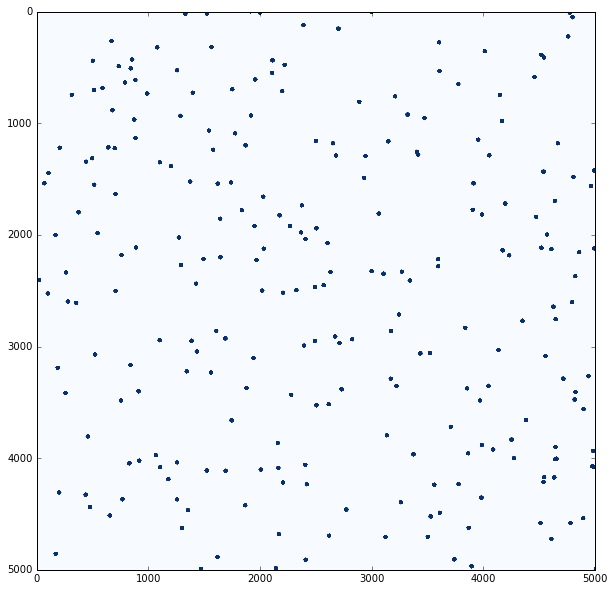

In [9]:
img1_array = Image.pil_2_array(img1)

plt.imshow( Image.rgb_2_mono(img1_array,'B'), cmap='Blues')

print "Catalog A:"
print "----------"
print df1

### Result of the simulation for the second image

Catalog B:
----------
      ID   r     x     y
0      1  20   666   898
1      2  20  3263  3361
2      3  20  3299   913
3      4  20  4545  3069
4      5  20   310   762
5      6  20  3853  1325
6      7  20  1299  4078
7      8  20   386  1822
8      9  20  4523  4192
9     10  20  1747  1520
10    11  20  1195  1385
11    12  20  4664  2713
12    13  20  2868  4061
13    14  20  4986  2127
14    15  20  3361  3973
15    16  20   676  1838
16    17  20  4862  1666
17    18  20   796   636
18    19  20  1611  1814
19    20  20  4805    37
20    21  20   474  3800
21    22  20  3378  1250
22    23  20  2465  1202
23    24  20  1562   316
24    25  20  1458  4990
25    26  20   237  3412
26    27  20  1104  4360
27    28  20  2114   546
28    29  20  4536  4150
29    30  20  2299   519
..   ...  ..   ...   ...
220  221  20  3377  3990
221  222  20   869   613
222  223  20  1779  3136
223  224  20  1872  3345
224  225  20  2937  2750
225  226  20  3745  4944
226  227  20  1364  2945
227

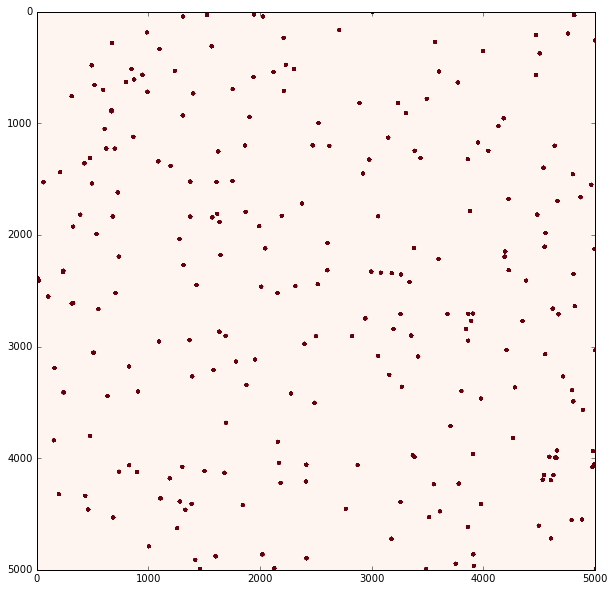

In [10]:
img2_array = Image.pil_2_array(img2)

plt.imshow( Image.rgb_2_mono(img2_array,'R'), cmap='Reds')

print "Catalog B:"
print "----------"
print df2

### Merge images

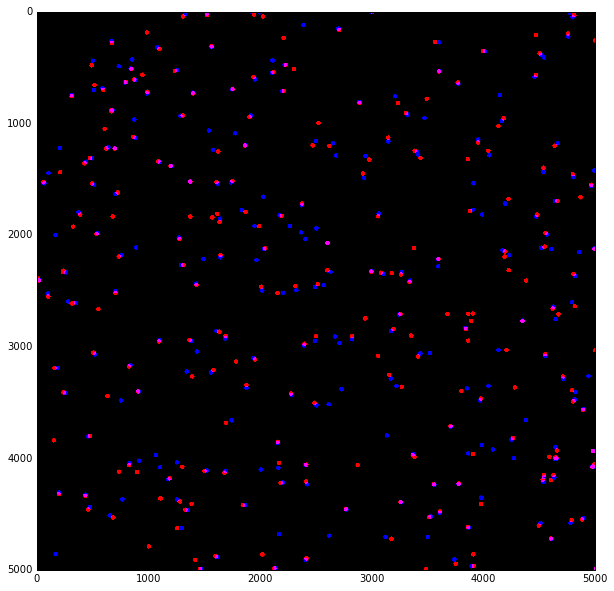

In [11]:
plt.imshow( Image.array_2_pil( img1_array+img2_array ) )

## Cross-matching

### Serial experiment

In [ ]:
def nn_search(catA,catB, dview=None):
    """
    """
    
    import pandas
    assert isinstance(catA,pandas.DataFrame)
    assert isinstance(catB,pandas.DataFrame)
    
    A = catA.copy()
    B = catB.copy()
    
    from astropy.coordinates import SkyCoord
    from astropy import units
    norm_fact = 500.0
    Ax_norm = A.x / norm_fact
    Ay_norm = A.y / norm_fact
    A_coord = SkyCoord(ra=Ax_norm, dec=Ay_norm, unit=units.deg)

    Bx_norm = B.x / norm_fact
    By_norm = B.y / norm_fact
    B_coord = SkyCoord(ra=Bx_norm, dec=By_norm, unit=units.deg)

    if dview:
        print "Running in parallel"
        # Encapsulate some variables to sand for processing
        def make_nn_search_parallel(foo,cat2):
            def pkg_nn_search(cat1,foo=foo,cat2=cat2):
                return foo(cat1,cat2)
            return pkg_nn_search

        # A-B
        from astropy.coordinates import match_coordinates_sky
        match_eps = make_nn_search_parallel(match_coordinates_sky,B_coord)
        #
        from numpy import arange,array_split,append
        A_list = [ A_coord[idx] for idx in array_split(arange(len(A_coord)),len(dview)) ]
        A_list_out = dview.map_sync(match_eps, A_list)
        #
        match_A_nn_idx, match_A_nn_sep = None, None
        for each_out in A_list_out:
            match_idx, match_sep, _d3d = each_out
            del _d3d
            if match_A_nn_idx is None:
                assert match_A_nn_sep is None
                match_A_nn_idx = match_idx
                match_A_nn_sep = match_sep.value
            else:
                match_A_nn_idx = append(match_A_nn_idx,match_idx)
                match_A_nn_sep = append(match_A_nn_sep,match_sep.value)

        # B-A
        from astropy.coordinates import match_coordinates_sky
        match_eps = make_nn_search_parallel(match_coordinates_sky,A_coord)
        #
        from numpy import arange,array_split,append
        B_list = [ B_coord[idx] for idx in array_split(arange(len(B_coord)),len(dview)) ]
        B_list_out = dview.map_sync(match_eps, B_list)
        #
        match_B_nn_idx, match_B_nn_sep = None, None
        for each_out in B_list_out:
            match_idx, match_sep, _d3d = each_out
            del _d3d
            if match_B_nn_idx is None:
                assert match_B_nn_sep is None
                match_B_nn_idx = match_idx
                match_B_nn_sep = match_sep.value
            else:
                match_B_nn_idx = append(match_B_nn_idx,match_idx)
                match_B_nn_sep = append(match_B_nn_sep,match_sep.value)
        
    else:
        print "Running in serial"
        from astropy.coordinates import match_coordinates_sky
        match_A_nn_idx, match_A_nn_sep, _d3d = match_coordinates_sky(A_coord, B_coord)
        match_B_nn_idx, match_B_nn_sep, _d3d = match_coordinates_sky(B_coord, A_coord)
        match_A_nn_sep = match_A_nn_sep.value
        match_B_nn_sep = match_B_nn_sep.value

    A['NN_in_B'] = B.ID[match_A_nn_idx].values
    B['NN_in_A'] = A.ID[match_B_nn_idx].values

    import numpy
    A_matched_pairs = zip(numpy.arange(len(match_A_nn_idx)),
                          match_A_nn_idx )
    B_matched_pairs = set(zip(match_B_nn_idx,
                              numpy.arange(len(match_B_nn_idx))))

    duplicate_pairs = []
    duplicate_dists = []
    for i,p in enumerate(A_matched_pairs):
        if p in B_matched_pairs:
            duplicate_pairs.append(p)
            duplicate_dists.append(match_A_nn_sep[i])

    A_matched_idx,B_matched_idx = zip(*duplicate_pairs)
    import pandas
    df_matched = pandas.DataFrame({ 'A_idx':A_matched_idx,
                                    'B_idx':B_matched_idx,
                                    'separation':duplicate_dists})
    df_matched = df_matched.set_index('A_idx')

    A.columns = [ 'A_'+c for c in A.columns ]
    B.columns = [ 'B_'+c for c in B.columns ]

    B_matched = B.iloc[df_matched.B_idx]
    B_matched['A_idx'] = df_matched.index
    B_matched = B_matched.set_index('A_idx')

    B_matched['dist'] = numpy.asarray(df_matched.separation * norm_fact, dtype=int)

    df = pandas.concat([A,B_matched],axis=1)
    return df


In [ ]:
%time df_match_serial = nn_search(df1,df2)
# from astropy.table import Table
# table_match = Table.from_pandas( df_match )
# table_match.show_in_notebook()

### Parallel experiment

In [ ]:
# Lets us see what happens in parallel
# First, run from the command line:
#$ ipcluster start -n 2

In [ ]:
try:
    import ipyparallel as ipp
    client = ipp.Client()
    client.ids
    dview = client[:]
except:
    dview = None

In [ ]:
%time df_match_parallel = nn_search(df1,df2,dview)

### Are they equal?

In [ ]:
df_match_parallel.equals(df_match_serial)

## [ This is for another notebook: the functions organized ;]

In [ ]:
# ---

def read_catalogs(A_filename, B_filename, column_names, sample_size=0):
    """
    """

    def read_fitsio(filename,column_names=None):
        """
        """
        import fitsio
        if True:
            catalog_data = fitsio.read(filename, columns=column_names, ext=1)
        # else:
        #     catalog_data = fitsio.read(filename, ext=1)
        return catalog_data


    A_data = read_fitsio(A_filename, column_names=column_names[0])
    B_data = read_fitsio(B_filename, column_names=column_names[1])

    if sample_size:
        A_data = sample(A_data, fraction=sample_size)

    return A_data,B_data

# ---

def get_coordinates(ra,dec):
    from astropy.coordinates import SkyCoord
    from astropy import units
    return SkyCoord(ra=ra, dec=dec, unit=units.deg)

# ---

def sample(data_array, fraction=0.1):
    """
    Returns a (normal) random sample from array' rows

    Input:
     - data_array : ~numpy.ndarray
            Array from where rows are randomly chosen
     - fraction : int, float
            Number between (0,array'length); limits are non-inclusive.
            If the number is higher (inclusive) than '1', it is assumed to be
            the absolute value for the sample size; otherwise, if between (0,1)
            it is assumed to be the relative, array-length multiplication factor.
    Output:
     - sampled_array : ~numpy.ndarray
            Rows are randomly chosen from a normal distribution, all same columns
    """
    import numpy
    nrows = len(data_array)

    assert fraction > 0, "ValueError: There is no sense in asking for 'fraction' <= 0"
    assert fraction < nrows, "ValueError: There is no sense in asking for 'fraction' >= array's length"

    nsamp = fraction if fraction >= 1 else fraction*nrows
    nsamp = int(nsamp)
    idx = numpy.random.randint(0, nrows, nsamp)
    sample_data = data_array[idx]

    return sample_data

# ---

def xmatch_nn(A_coord,B_coord,parallel=False):
        if parallel:
            match_A_nn_idx, match_A_nn_sep = xmatch_nn_parallel(A_coord,B_coord)
        else:
            match_A_nn_idx, match_A_nn_sep = xmatch_nn_serial(A_coord,B_coord)
        return (match_A_nn_idx, match_A_nn_sep)

# ---

def xmatch_nn_serial(pin, neiborhood):
    """
    Nearest-Neighbor search

    Input:
     - pin : ~astropy.coordinates.SkyCoord
            reference catalog (catalog "A")
     - neiborhood : ~astropy.coordinates.SkyCoord
            matching catalog (catalog "B")

    Output:
     - tuple with ~numpy.ndarray , ~astropy.units.Quantity
            array of respective (to 'pin') index entries in 'neiborhood'
            , array of respective pair distances
    """
    A_coord = pin
    B_coord = neiborhood

    from astropy.coordinates import SkyCoord
    assert isinstance(A_coord,SkyCoord)
    assert isinstance(B_coord,SkyCoord)

    from astropy.coordinates import match_coordinates_sky
    match_A_nn_idx, match_A_nn_sep, _d3d = match_coordinates_sky(A_coord,B_coord)

    assert len(match_A_nn_idx) == len(A_coord)
    assert match_A_nn_idx.max() < len(B_coord)

    return (match_A_nn_idx, match_A_nn_sep.value)

# ---

def xmatch_nn_parallel(A_coord,B_coord,nprocs=2):
    """
    """
    
    def parallel_setup(nprocs=2):
        """
        Run xmatch in parallel

        It splits the first array in 'nprocs' for parallel processing,
        then it concatenates the outputs and return that.
        """
        #TODO: do all the verifications for parallel run

        # Lets us see what happens in parallel
        # First, run from the command line:
        #$ ipcluster start -n 2
        try:
            import ipyparallel as ipp
            client = ipp.Client()
            client.ids
            dview = client[:]
        except:
            dview = None
        return dview

    # ---

    dview = parallel_setup(nprocs=2)
    if not dview:
        return False

    print "Running in parallel"

    # Encapsulate some variables to send for processing
    def make_nn_search_parallel(foo,cat2):
        def pkg_nn_search(cat1,foo=foo,cat2=cat2):
            return foo(cat1,cat2)
        return pkg_nn_search
    # ---

    # Split array (of coordinates) in N pieces
    def split_array(A_coord,N):
        from numpy import arange,array_split
        index = arange(len(A_coord))
        A_pieces = [ A_coord[idx]   for idx in array_split( index,N ) ]
        return A_pieces

    # Join array/list of tuples in N pieces
    def join_array(A_coord_outs):
        from numpy import append
        match_A_nn_idx = None
        match_A_nn_sep = None
        for each_out in A_coord_outs:
            match_idx, match_sep, _d3d = each_out
            del _d3d
            if match_A_nn_idx is None:
                assert match_A_nn_sep is None
                match_A_nn_idx = match_idx
                match_A_nn_sep = match_sep.value
            else:
                match_A_nn_idx = append(match_A_nn_idx,match_idx)
                match_A_nn_sep = append(match_A_nn_sep,match_sep.value)
        return (match_A_nn_idx,match_A_nn_sep)
    # ---

    # A-B
    # from astropy.coordinates import match_coordinates_sky
    foo_match_coordinates = make_nn_search_parallel(xmatch_nn, B_coord)

    A_coord_pieces = split_array(A_coord,N=len(dview))

    A_coord_outs = dview.map_sync( foo_match_coordinates, A_coord_pieces )

    match_A_nn_idx,match_A_nn_sep = join_array(A_coord_outs)

    return (match_A_nn_idx,match_A_nn_sep.value)

# ---

def match_pairs(match_A_nn_idx,match_B_nn_idx,match_A_nn_sep):
    import numpy
    A_matched_pairs = zip(numpy.arange(len(match_A_nn_idx)),
                          match_A_nn_idx )
    B_matched_pairs = set(zip(match_B_nn_idx,
                          numpy.arange(len(match_B_nn_idx))))

    matched_pairs = []
    matched_dists = []
    for i,p in enumerate(A_matched_pairs):
        if p in B_matched_pairs:
            matched_pairs.append(p)
            matched_dists.append(match_A_nn_sep[i])

    A_matched_idx,B_matched_idx = zip(*matched_pairs)
    
    return (A_matched_idx, B_matched_idx, matched_dists)

# ---

def assemble_indexes(A_matched_idx,B_matched_idx,matched_dists):
    import pandas
    df_matched_idx = pandas.DataFrame({ 'A_idx':A_matched_idx,
                                        'B_idx':B_matched_idx,
                                        'separation':matched_dists})
    df_matched_idx = df_matched_idx.set_index('A_idx')
    return df_matched_idx

# ---

def merge_catalogs(A,B,df_matched_idx):

    A.columns = [ 'A_'+c for c in A.columns ]
    B.columns = [ 'B_'+c for c in B.columns ]

    B_matched = B.iloc[df_matched_idx.B_idx]
    B_matched['A_idx'] = df_matched_idx.index
    B_matched = B_matched.set_index('A_idx')

    B_matched['dist'] = numpy.asarray(df_matched_idx.separation)

    df = pandas.concat([ A,B_matched ],axis=1)
    
    return df

# ---


In [ ]:
class Mock:
    @staticmethod
    def normalize_coordinates(A,B,norm_factor):

        def _normalize_coordinates(x, y, norm_fact):
            from astropy.coordinates import SkyCoord
            from astropy import units
            x_norm = x / norm_fact
            y_norm = y / norm_fact
            coord = SkyCoord(ra=x_norm, dec=y_norm, unit=units.deg)
            return coord

        A_coord = _normalize_coordinates(A.x,A.y,norm_factor)
        B_coord = _normalize_coordinates(B.x,B.y,norm_factor)
        return A_coord,B_coord

# ---
# A_filename = 'cs82/cs82.fits'
# B_filename = 'spies/spies.fits'

# column_names = (['OBJID','RA','DEC'],['id','RA_ch1','DEC_ch1'])
# A_data, B_data = read_catalogs(A_filename,B_filename,column_names)

# from astropy.table import Table
# A = Table(A_data)
# B = Table(B_data)

# A_coord = get_coordinates(A['RA'],A['DEC'])
# B_coord = get_coordinates(B['RA_ch1'],B['DEC_ch1'])

import pandas
assert isinstance(df1,pandas.DataFrame)
assert isinstance(df2,pandas.DataFrame)
A = df1.copy()
B = df2.copy()
norm_factor=500

A_coord,B_coord = Mock.normalize_coordinates(A, B, norm_factor)

match_A_nn_idx, match_A_nn_sep = xmatch_nn(A_coord, B_coord)
match_B_nn_idx, match_B_nn_sep = xmatch_nn(B_coord, A_coord)
del A_coord,B_coord

A_matched_idx, B_matched_idx, matched_dists = match_pairs(match_A_nn_idx, match_B_nn_idx, match_A_nn_sep)

import numpy
matched_dists = numpy.asarray([ _d * norm_factor for _d in matched_dists ], dtype=int)

df_matched_idx = assemble_indexes(A_matched_idx, B_matched_idx, matched_dists)
del A_matched_idx, B_matched_idx, matched_dists

matched_catalog = merge_catalogs(A,B,df_matched_idx)
del df_matched_idx

In [ ]:
from astropy.table import Table
tab = Table.from_pandas(matched_catalog)
print tab

In [ ]:
for fat in df_match_serial.columns:
    print "Checking column {}".format(fat)
    assert fat in df_match_parallel.columns
    if fat not in matched_catalog.columns:
        print "Removing {}".format(fat)
        del df_match_serial[fat]
        del df_match_parallel[fat]
        
matched_catalog.equals(df_match_serial)

In [ ]:
tab.show_in_notebook()